In [24]:
using Unitful, UnitfulRecipes           # Unidades físicas
using FFTW                              # Transformadas de Fourier
using Plots, PlotThemes, ColorSchemes   # Gráficos
using Spectra                           # Funciones espectrales

import PhysicalConstants.CODATA2014: c_0
c = c_0 |> u"km/ps"

theme(:juno)
default(size=(800,400), linewidth=2, palette=:seaborn_deep6)

Antes de empezar, adaptamos las funciones `fft`, `ifft`, `trapz`, y `fwhm` para que admitan valores con unidades.

In [25]:
function ufft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return fft(yval, dim)*yunit
end

function uifft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return ifft(yval, dim)*yunit
end

function utrapz(x, y)
    xval, xunit = ustrip.(x), unit(x[1])
    yval, yunit = ustrip.(y), unit(y[1])
    return trapz(xval, yval)*yunit
end 

function fwhm(x, y)
    xval, xunit = ustrip.(x), unit(x[1])
    yval, yunit = ustrip.(y), unit(y[1])
    return peakmeas(xval |> Vector, yval |> Vector)[3]
end

fwhm (generic function with 1 method)

Tomamos los valores de $D$, $S_0$ y $\alpha$ de los specs de la fibra SMF28, y consideramos longitud de onda de operación de $\lambda_0=1550\,\mathrm{nm}$. Calculamos $\beta_1$ y $\beta_2$.

In [26]:
λ = 1550u"nm"
α = uconvertp(NoUnits,0.02u"dB")*u"km^-1"
D = 18u"ps/(nm*km)"
S0 = 0.092u"ps/(nm^2*km)"

β2 = -λ^2*D/(2π*c) |> u"ps^2/km"
β3 = (S0+2*D/λ)/(2π*c^2)*λ^4 |> u"ps^3/km"

1.177755862911665 ps^3 km^-1

Elejimos propagar un pulso gausiano de ancho $T_0 = 10\, \mathrm{ps}$. En función de eso calculamos la longitud de dispersión $L_D$ para tener un orden de escala para la dimensión $z$

In [27]:
T0 = 10u"ps"
P0 = 10u"mW"

LD = T0^2/abs(β2)
Leff = 1/α |> u"km"

0.9954054173515269 km

Vamos a mirar el comportamiento en un rango de $0 \le z \le 10 \, L_D$, discretizando el dominio a un número $N$ de puntos que equilibre precisión y velocidad. Calculamos el ancho que se espera tenga el pulso al final del recorrido $T_F$ para tener un orden de escala para la dimensión $t$.

In [28]:
N = 512
z = range(0u"km", 10*LD, N)

Tf = sqrt(1+z[end]^2/LD^2)*T0

100.4987562112089 ps

Miramos la forma del pulso en una ventana de $-5\,T_F \le t \le 5\,T_F$, también discretizado a $N$ puntos. Encontramos en función de esa discretización el dominio de frecuencias $f$

Definimos una grilla de coordenadas discretas $(i,\, j)$ en donde vamos a evaluar el problema. Esta grilla se va a usar tanto para indexar coordenadas $(z,\, t)$ como $(z,\, f)$.

In [29]:
t = range(-4*Tf, 4*Tf, N)

Δf = 1/(t[2]-t[1]) |> u"GHz"
f = fftfreq(N, Δf) |> fftshift

ij = Iterators.product(1:N, 1:N) |> collect;

En este intervalo temporal definimos el pulso gaussiano de ancho $T_0$ 

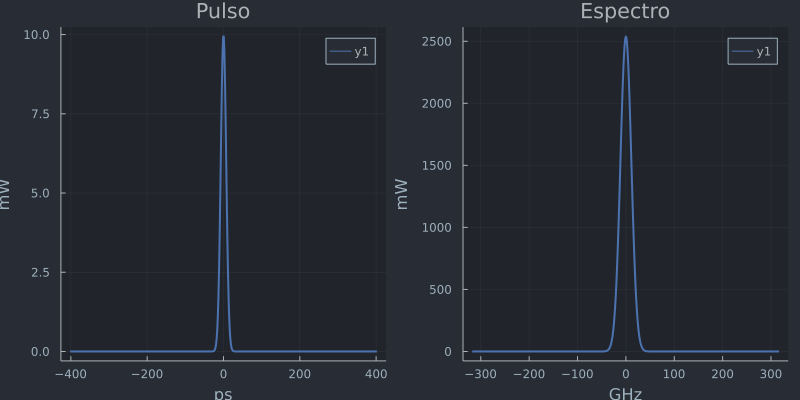

In [30]:
At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))
Af0 = ufft(At0) |> fftshift

p1 = plot(t, At0.^2, title="Pulso")
p2 = plot(f, abs.(Af0).^2, title="Espectro")
plot(p1, p2)

Calculamos la evolución del espectro a lo largo de la fibra, usando el resultado
$$\hat A(z,w) = \hat A(0, w) \exp\left[i \frac{\beta_2}2 w^2 z\right] \longrightarrow A_f[i, j] = A_{f0}[j]\exp\left[i \frac{\beta_2}2 w_j^2 z_i\right]$$ 

In [31]:
A((i, j)) = Af0[j]*exp(im*β2/2*(2π*f[j])^2*z[i])

A (generic function with 1 method)

Evaluamos $A_f[i,j]$ en los puntos $(i,\, j) \leftrightarrow(z,\, f)$. Antitransformamos Fourier a lo largo de la dimensión $j$ para obtener el resultado $A_t[i,j]$ en el dominio $(i,\, j) \leftrightarrow(z,\, t)$

In [32]:
Af = A.(ij)
At = uifft(Af, 2)*sqrt(N);

Hay varias formas de visualizar el resultado: Una forma es ver una animación de la evolución del pulso, donde el eje temporal de la animación representa la dimensión $z$ de la fibra.

┌ Info: Saved animation to 
│   fn = /tmp/jl_3ovvpa.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_3ovvpa.gif")
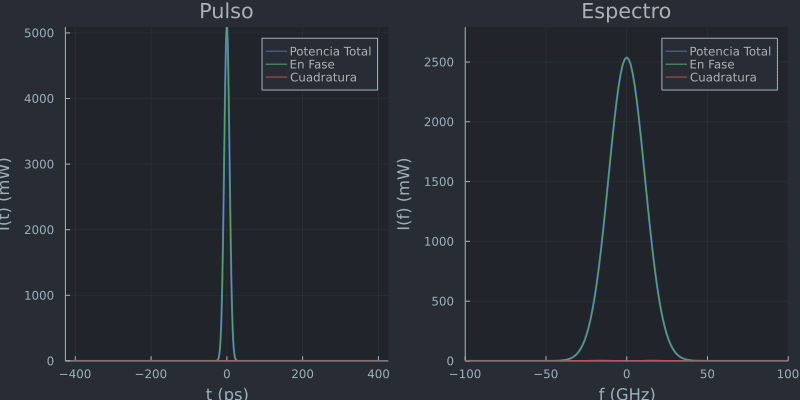

In [33]:
function animate_pulse(t, At, f, Af)
    ymaxf = maximum(abs.(Af).^2)*1.1
    ymaxt = maximum(abs.(At).^2)
    xlims = (-1/T0, 1/T0) .|> u"GHz"
        
    @gif for i in 1:N   
        p2 = plot(f, abs.(Af[i,:]).^2; xlims=xlims, ylims=(0u"W", ymaxf), label="Potencia Total", xlabel = "f", ylabel = "I(f)", title="Espectro")
        plot!(f, real(Af[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(f, imag(Af[i,:]).^2, label="Cuadratura", linewidth=1)
        
        p1 = plot(t, abs.(At[i,:]).^2; ylims=(0u"W", ymaxt), label="Potencia Total", xlabel = "t", ylabel = "I(t)", title="Pulso")
        plot!(t, real(At[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(t, imag(At[i,:]).^2, label="Cuadratura", linewidth=1)
        plot(p1, p2, layout=(1,2))
    end every 8
end

animate_pulse(t, At, f, Af)

Otra forma es ver un _heatmap_ de la potencia distribuida en el tiempo $|A(z,t)|^2$ y en el espectro $|\hat A(z,w)|^2$, con eje $z$ en escala logarítmica.

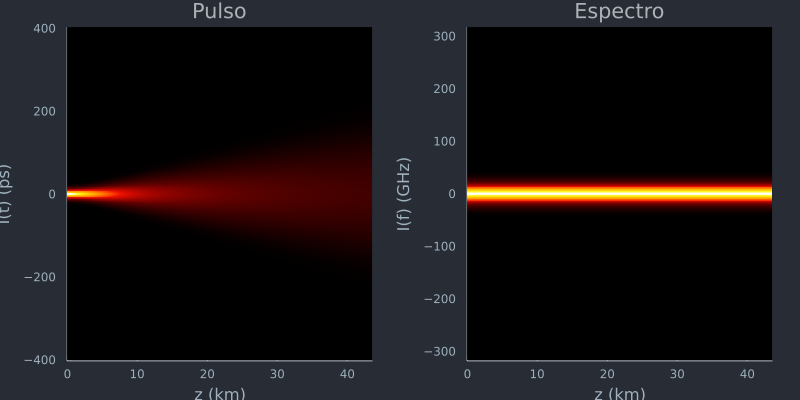

In [34]:
function heatmap_pulse(z, t, At, f, Af) 
    p1 = heatmap(z, t, abs.(At').^2, xlabel="z", ylabel="I(t)", title="Pulso")
    p2 = heatmap(z, f, abs.(Af').^2, xlabel="z", ylabel="I(f)", title="Espectro")
    plot(p1, p2, layout=(1,2), colorbar=false, zaxis=:log)
end

heatmap_pulse(z, t, At, f, Af)

La primera visualización es interesante porque muestra la redistribución de las componentes del pulso gaussiano a lo largo del recorrido de la fibra. La segunda visualización ilustra la similitud de este fenómeno con la dispersión espacial de un haz de luz en el espacio. En ambos casos se nota que el pulso se ensancha, pero el espectro no varía.

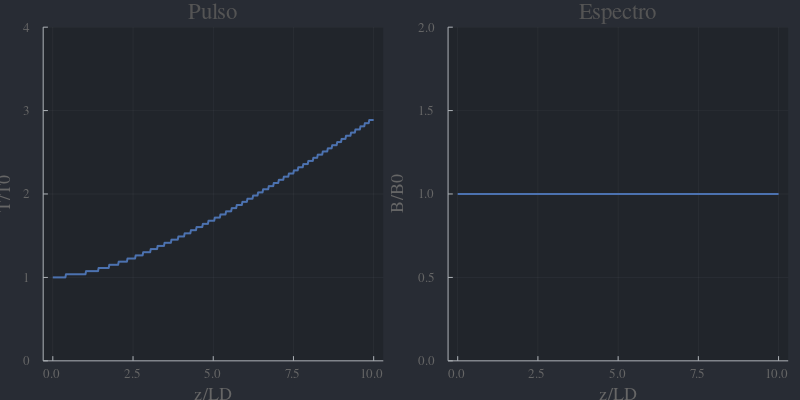

In [12]:
pw = [fwhm(t, abs.(A)) for A in eachrow(At)]
bw = [fwhm(f, abs.(A)) for A in eachrow(Af)]

pw = pw./pw[1]
bw = bw./bw[1];
p1 = plot(z./LD, pw, xlabel="z/LD", ylabel="T/T0", ylims=(0, maximum(pw)*1.1 |> ceil), title="Pulso")
p2 = plot(z./LD, bw, xlabel="z/LD", ylabel="B/B0", ylims=(0, maximum(bw)*1.1 |> ceil), title="Espectro")
plot(p1, p2, legend=false)

Se puede observar que la dispersión del pulso ya es apreciable en $z=L_D$. En $z=7\,L_D$ el ancho del pulso ya se duplicó respecto a su valor original. Hay que tomarlo en cuenta ya que:
- El ensanchamiento del pulso puede provocar interferencia intersímbolo en el receptor
- La potencia pico va invérsamente proporcional al ancho del pulso, y puede ser menor que la sensibilidad del receptor.  

Ahora consideramos la atenuación. Usamos la longitud característica de atenuación $L_{eff}$ para definir el eje $z$, ya que usar $L_D$ puede resultar en un intervalo demasiado corto o demasiado largo para apreciar la atenuación. Usamos el resultado de la propagación con atenuación y dispersión de segundo orden

$$\hat A(z,w) = \hat A(0, w) \exp\left[i \frac{\beta_2}2 w^2 z\right]\exp\left[-\frac \alpha 2 z\right] \longrightarrow A_f[i, j] = A_{f0}[j]\exp\left[i \frac{\beta_2}2 w_j^2 z_i\right] \exp\left[-\frac \alpha 2 z_i\right]$$ 

In [13]:
A((i, j)) = Af0[j]*exp(im*β2/2*(2π*f[j])^2*z[i])*exp(-α*z[i]/2)

z = range(0u"km", 5*Leff, N)

Af = A.(ij)
At = uifft(Af, 2);

┌ Info: Saved animation to 
│   fn = /tmp/jl_qheIna.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_qheIna.gif")
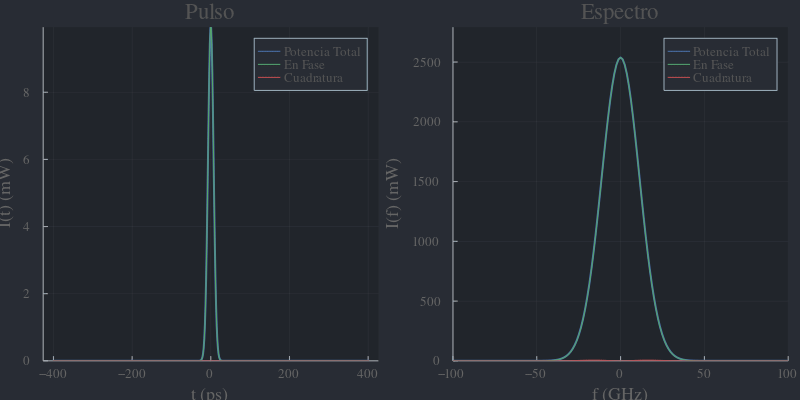

In [14]:
animate_pulse(t, At, f, Af)

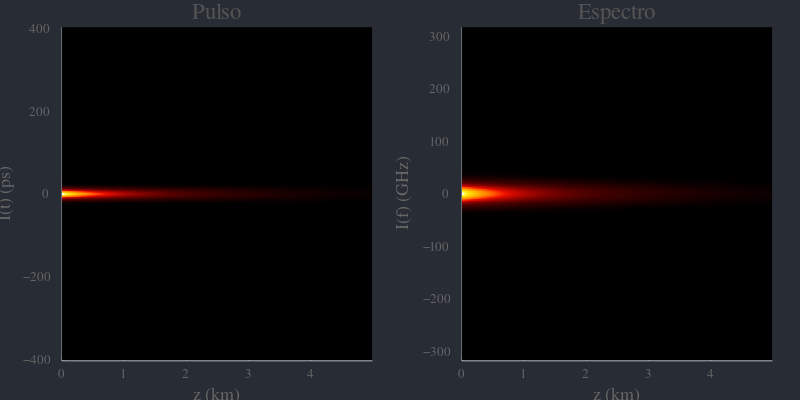

In [15]:
heatmap_pulse(z, t, At, f, Af)

Para este valor de $T_0$ en particular se nota que la atenuación predomina sobre la GVD (no siempre se cumple esto, por ejemplo para valores menores de $T_0$, la GVD es más rápida). 

Evaluamos la potencia del pulso en función de $z$, y lo comparamos con la expresión de decaimiento exponencial según $\alpha$ de la potencia del pulso inicial para validar el resultado esperado.

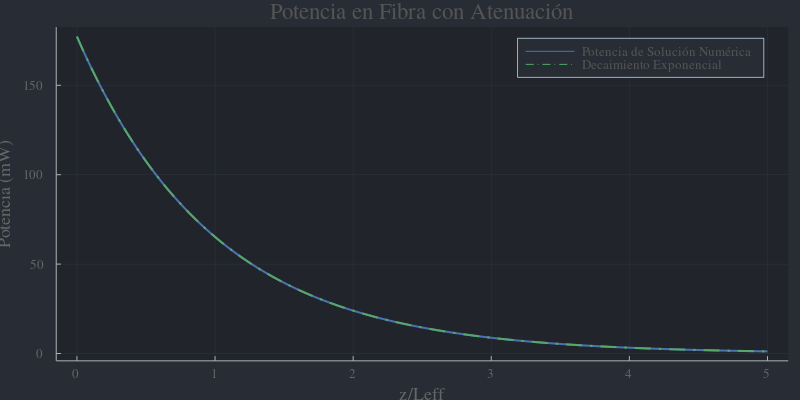

In [16]:
power(x, y) = utrapz(x, abs.(y).^2)

pow = [power(t, A) for A in eachrow(At)]

plot(z/Leff, pow, xlabel="z/Leff", ylabel="Potencia", title="Potencia en Fibra con Atenuación", label="Potencia de Solución Numérica")
plot!(z/Leff, power(t, At0).*exp.(-α*z), linestyle=:dashdot, label="Decaimiento Exponencial")

Ahora estudiamos la dispersión de tercer orden, usando el resultado que contempla el efecto de $\beta_2$ y de $\beta_3$
$$A(z, t) = \frac 1 {2\pi} \int_{-\infty}^\infty \hat A (0, w)\exp\left[\frac i 2 \beta_2 w^2 z + \frac i 6 \beta_3 w^3 z - i w t\right] dw \longrightarrow A_t[i,j] = \frac 1 {2\pi} \sum_{k=1}^{N} A_{f0}[k]\exp\left[\frac i 2 \beta_2 w_k^2 z_i + \frac i 6 \beta_3 w_k^3 z_i - i w_k t_j\right] \Delta w $$
Primero evaluamos únicamente la dispersión de tercer orden, usando la ecuación anterior con $\beta_2=0$

In [17]:
function A((i, j))
    w = 2π*f
    arg = Af0.*exp.(im/6*β3*w.^3*z[i]-im*w*t[j])
    return utrapz(w, arg)/(2π)
end

A (generic function with 1 method)

Hay que incrementar muchísimo el rango de $z$ para apreciar el efecto de tercer orden para este valor de $T_0$, ya que en este caso se empieza a ver recién en valores de $z\gg L_D$.

In [18]:
z = range(0u"km", 3000*LD, N)

At = A.(ij) 
At = fftshift(At, 2)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

┌ Info: Saved animation to 
│   fn = /tmp/jl_YC7com.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_YC7com.gif")
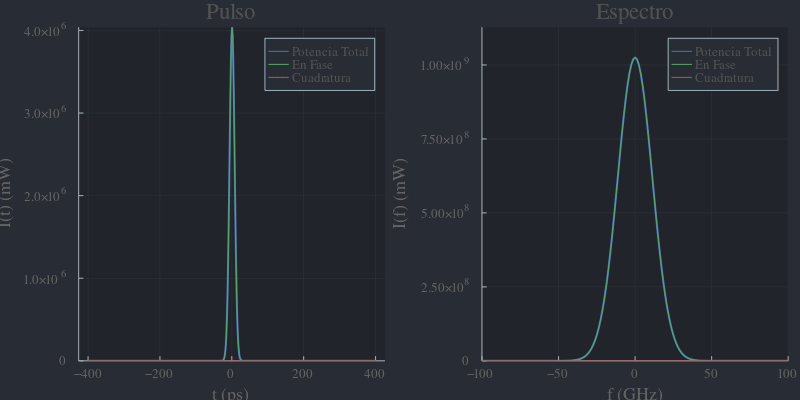

In [19]:
animate_pulse(t, At, f, Af)

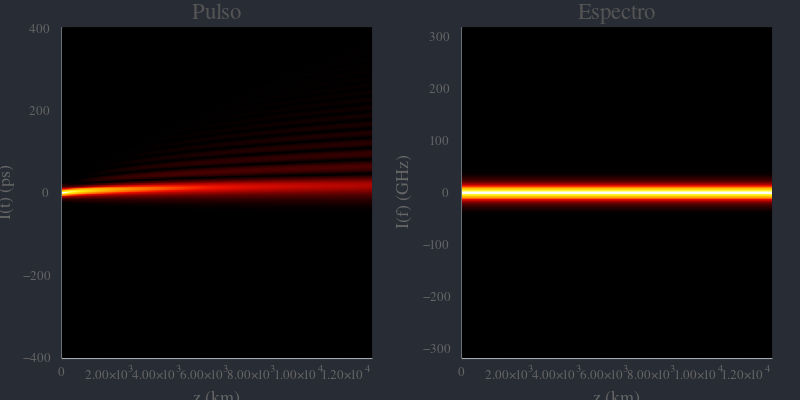

In [20]:
heatmap_pulse(z, t, At, f, Af)

Vemos que la dispersión de tercer orden tampoco cambia el ancho de banda del pulso, únicamente su forma en el dominio del tiempo.

Es de esperar que el efecto de tercer orden será despreciable respecto al de segundo orden para este pulso propagándose en esta fibra. Lo verificamos incluyendo el término $\beta_2$ a la ecuación.

In [21]:
function A((i, j))
    w = 2*pi*f
    arg = Af0.*exp.(im/2*β2*w.^2*z[i]+im/6*β3*w.^3*z[i]-im*w*t[j])
    return utrapz(w, arg)/(2π)
end

z = range(0u"km", 10*LD, N)

At = A.(ij) 
At = fftshift(At, 2)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

┌ Info: Saved animation to 
│   fn = /tmp/jl_Dg8MN9.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_Dg8MN9.gif")
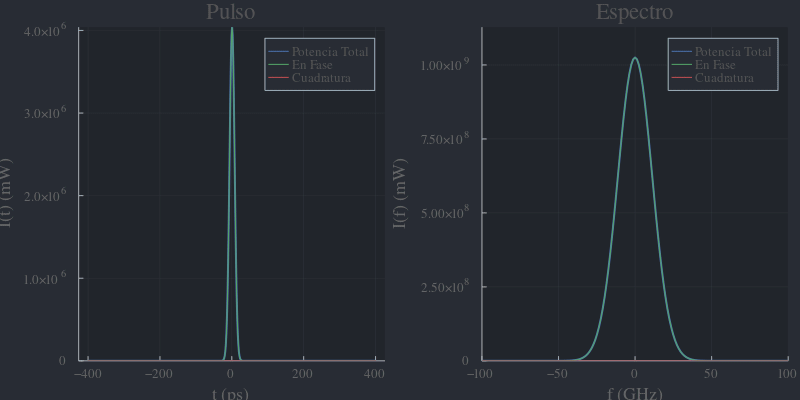

In [22]:
animate_pulse(t, At, f, Af)

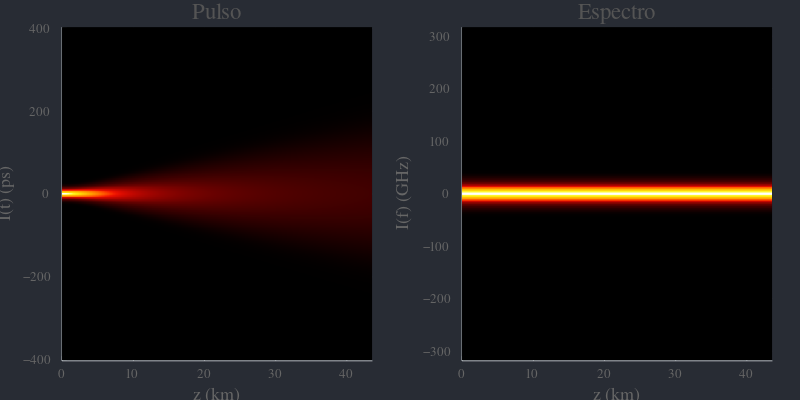

In [23]:
heatmap_pulse(z, t, At, f, Af)

Efectivamente se nota que la dispersión de tercer orden es despreciable respecto a la de segundo orden en estas condiciones. Sin embargo esta simulación es buena para verificar que la expresión integral recupera la expresión utilizada en el inciso a.